Dropdown(description='Node ID:', index=9, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 1…

Output()

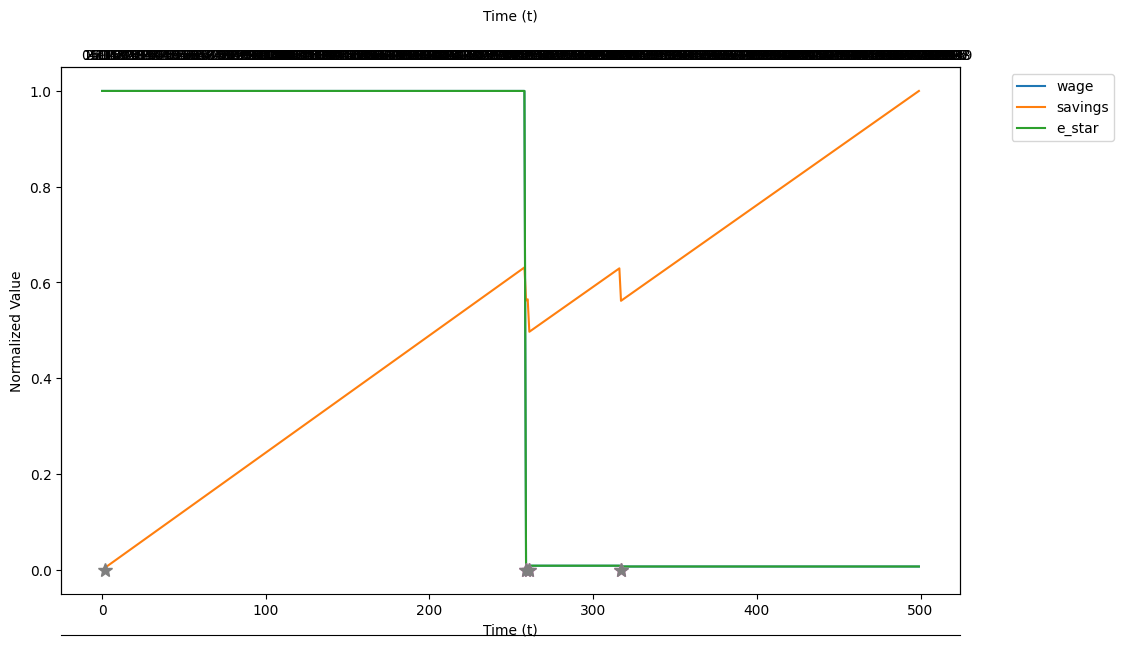

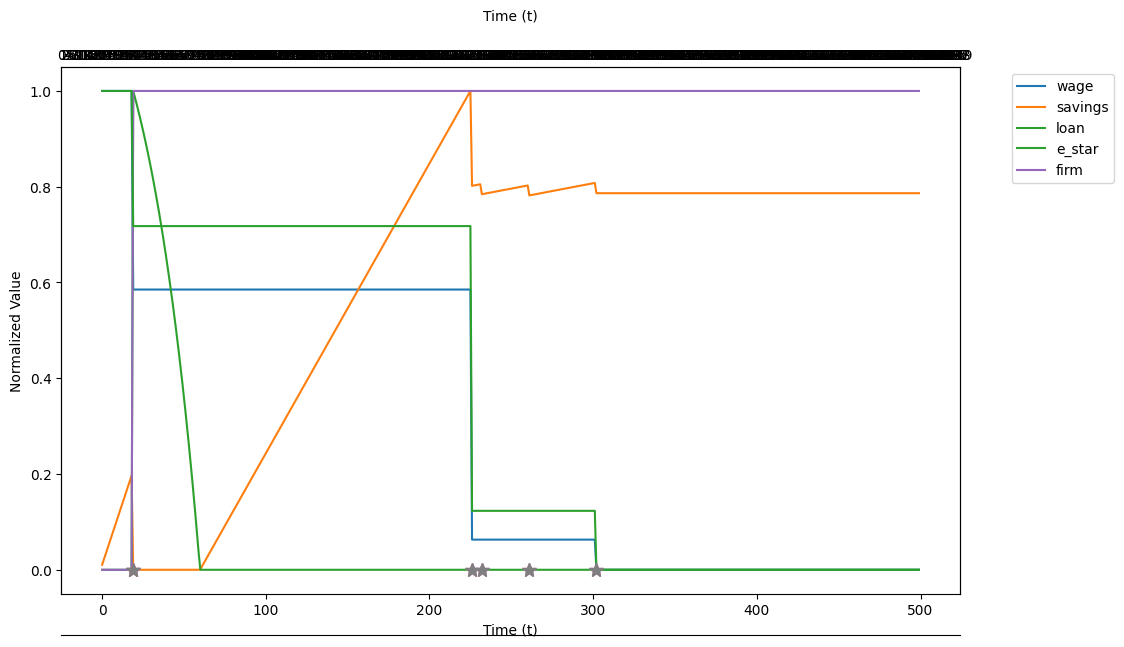

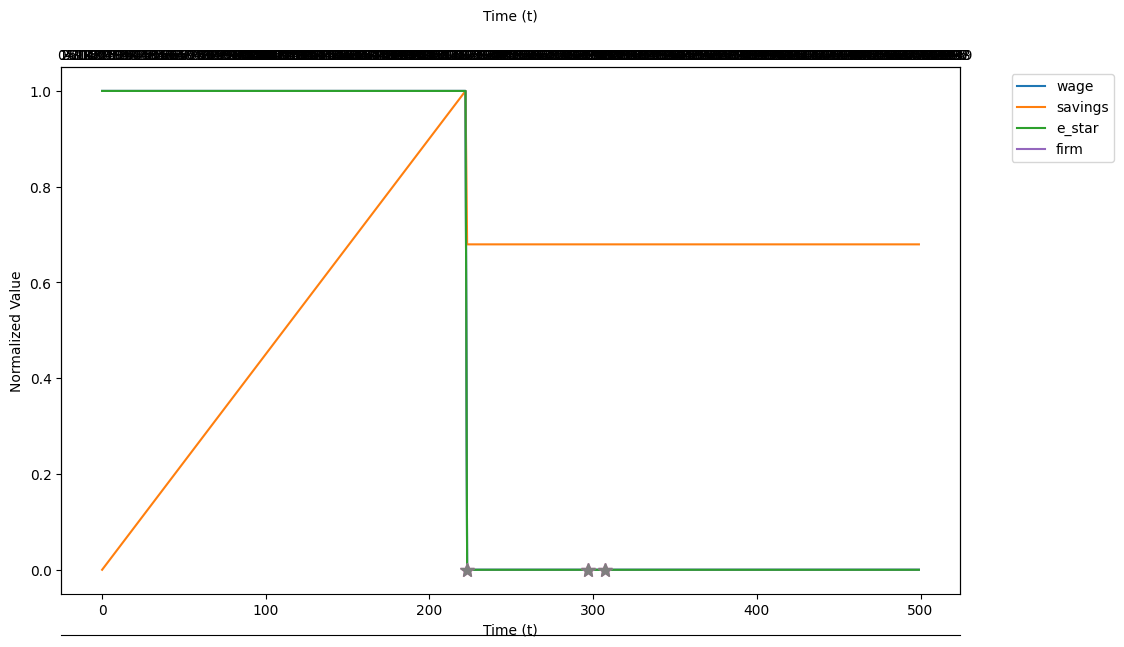

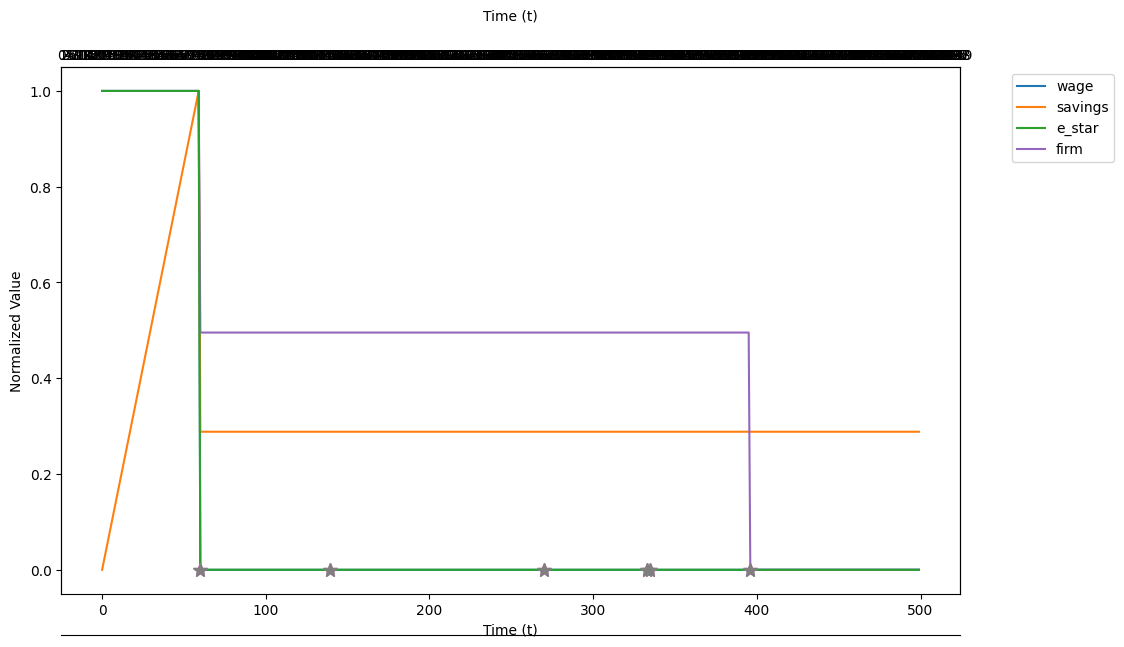

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Load the CSV file
csv_path = "../code/data/N600t500r20lendingrate3.csv"
df = pd.read_csv(csv_path)

# Pre-filter data by node ID
node_data = {}
for node_id in df["id"].unique():
    node_df = df[df["id"] == node_id].copy()
    node_df.sort_values("t", inplace=True)
    node_data[node_id] = node_df

# Pre-calculate normalized values for each node
normalized_data = {}
candidate_cols = ["wage", "savings", "loan", "e_star", "firm", "a", "beta", "links", "component", "rate", "U_self", "e_self", "e_star"]
binary_cols = ["startup", "thwart", "borrow", "move", "go"]
for node_id, node_df in node_data.items():
    norm_node_data = {}
    for col in candidate_cols:
        if col in node_df.columns:
            col_data = node_df[col].astype(float)
            cmin, cmax = col_data.min(), col_data.max()
            if cmax - cmin == 0:
                with log_area:
                    print(f"  - {col}: constant value, skipping normalization")
                norm_node_data[col] = None # Store None for constant values
            else:
                norm_vals = (col_data - cmin) / (cmax - cmin)
                norm_node_data[col] = norm_vals
    for col in binary_cols:
        if col in node_df.columns:
            norm_node_data[col] = node_df[col]
    normalized_data[node_id] = norm_node_data

# Create the output area
log_area = widgets.Output() # MOVE THIS LINE HERE

# Function to update the plot
previous_figure = None
def update_plot(node_id):
    global previous_figure
    with log_area:
        print(f"Updating plot for node ID={node_id}")
    
    if previous_figure:
        plt.close(previous_figure)

    fig, ax = plt.subplots(figsize=(10, 6))
    lines = {}
    for col in candidate_cols:
        line, = ax.plot([], [], label=col)
        lines[col] = line

    ax.set_xlabel("Time (t)")
    ax.set_ylabel("Normalized Value")
    # ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left") # REMOVE LEGEND HERE
    fig.tight_layout()

    if node_id in normalized_data:
        norm_node_data = normalized_data[node_id]
        node_df = node_data[node_id]
        plotted_lines = [] # ADD THIS LINE
        for col, line in lines.items():
            if col in norm_node_data:
                if norm_node_data[col] is None: # Check for None
                    with log_area:
                        print(f"  - {col}: constant value, skipping plot")
                    line.set_data([], [])
                elif np.all(norm_node_data[col] == 0):
                    with log_area:
                        print(f"  - {col}: all zeros, skipping")
                    line.set_data([], [])
                else:
                    line.set_data(node_df["t"], norm_node_data[col])
                    with log_area:
                        print(f"  - {col}: x={len(node_df['t'])}, y={len(norm_node_data[col])}")
                    plotted_lines.append(line) # ADD THIS LINE
            else:
                line.set_data([], [])
        
        for col in binary_cols:
            if col in norm_node_data:
                event_times = node_df["t"][norm_node_data[col] == 1]
                ax.plot(event_times, [0] * len(event_times), "*", label=col, markersize=10)
                with log_area:
                    print(f"  - {col}: {len(event_times)} events")
        
        # Add timeline below the axis
        ax2 = ax.twiny()
        ax2.set_xlim(ax.get_xlim())
        ax2.set_xticks(node_df["t"].unique())
        ax2.set_xticklabels(node_df["t"].unique(), rotation=90, fontsize=8)
        ax2.tick_params(axis='x', which='both', length=0)
        ax2.spines['bottom'].set_position(('outward', 30))
        ax2.set_xlabel("Time (t)", labelpad=20)
        
        ax.relim()
        ax.autoscale_view()
        
        # ADD LEGEND HERE
        if plotted_lines:
            ax.legend(handles=plotted_lines, bbox_to_anchor=(1.05, 1), loc="upper left")
        
        fig.canvas.draw()
        fig.canvas.flush_events()
        plt.draw()
        display(fig.canvas)
        previous_figure = fig
    else:
        with log_area:
            print(f"No data for node ID {node_id}")

# Create the dropdown
unique_ids = sorted(df["id"].unique())
dropdown = widgets.Dropdown(
    options=unique_ids,
    description="Node ID:",
    value=unique_ids[9],
    style={'description_width': 'initial'}
)

# Callback function
def on_value_change(change):
    with log_area:
        clear_output(wait=True)
        print("Dropdown changed to:", change["new"])
        update_plot(change["new"])

# Attach the callback
dropdown.observe(on_value_change, names="value")

# Display the widgets
display(dropdown)
display(log_area)

# Initial plot
update_plot(dropdown.value)